In [1]:
import os
import sys
import math
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from collections import Counter
import imutils
from keras.models import Model
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import model_from_json
from tensorflow.keras.backend import resize_images

Using TensorFlow backend.
/home/akshat/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akshat/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akshat/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akshat/.local/lib/python3.6/site-packages/tensorflow/python

In [2]:
def plot_colors(hist, centroids):
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar

In [3]:
def centroid_histogram(clt):
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

In [4]:
#This has the best result
def extractSkin3(image, color, default = True):
#     print(color)
#     color.reverse() #bgr
#     color[0] =   16 +  65.738*color[2]/256 + 129.057*color[1]/256 +  25.064*color[0]/256
#     Cb = 128 -  37.945*color[2]/256 -  74.494*color[1]/256 + 112.439*color[0]/256
#     Cr = 128 + 112.439*color[2]/256 -  94.154*color[1]/256 -  18.285*color[0]/256
#     thresh = 20
#     print(color)


    if default == False:
        color.reverse() #bgr
    #     cv2.imshow('domcol', np.uint8( [[color]] ))
        color = cv2.cvtColor( np.uint8( [[color]] ), cv2.COLOR_BGR2YCrCb)[0][0]
        thresh = 50 

    
    # Taking a copy of the image
    img = image.copy()
    # Converting from BGR Colours Space to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)

    # Defining HSV Threadholds
    if default == True:
        skin_ycrcb_mint = np.array((0, 133, 77))
        skin_ycrcb_maxt = np.array((255, 173, 127))
    else:
        skin_ycrcb_mint = np.array([color[0] - thresh, color[1] - thresh, color[2] - thresh])
        skin_ycrcb_maxt = np.array([color[0] + thresh, color[1] + thresh, color[2] + thresh])

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask =  cv2.inRange(img, skin_ycrcb_mint, skin_ycrcb_maxt)
    
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    skinMask = cv2.erode(skinMask, kernel, iterations = 2)
    skinMask = cv2.dilate(skinMask, kernel, iterations = 2)
    
    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_YCR_CB2BGR)

In [5]:
def get_dominant_color(image, k=4, image_processing_size = None):
    """
    takes an image as input
    returns the dominant color of the image as a list
    
    dominant color is found by running k means on the 
    pixels & returning the centroid of the largest cluster

    processing time is sped up by working with a smaller image; 
    this resizing can be done with the image_processing_size param 
    which takes a tuple of image dims as input

    >>> get_dominant_color(my_image, k=4, image_processing_size = (25, 25))
    [56.2423442, 34.0834233, 70.1234123]
    """
    #resize image if new dims provided
    if image_processing_size is not None:
        image = cv2.resize(image, image_processing_size, 
                            interpolation = cv2.INTER_AREA)
    
    
    
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    #reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    #cluster and assign labels to the pixels 
    clt = KMeans(n_clusters = k)
    labels = clt.fit_predict(image)

    #count labels to find most popular
    label_counts = Counter(labels)

    #subset out most popular centroid
    dominant_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
    
    hist = centroid_histogram(clt)
    bar = plot_colors(hist, clt.cluster_centers_)
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()

    return list(dominant_color)

In [6]:
def detectface(image):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    color = 0
    fobj = image 
    flag = 0
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
        fobj = image[y:y+h, x:x+w]
        flag = 1
    
    if flag == 1:
        color = get_dominant_color(fobj)
    
    cv2.imshow('face', fobj)
    
    
    return color, flag
    

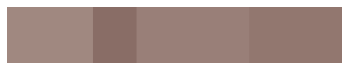

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


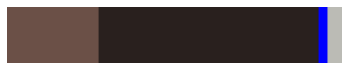

In [7]:
vid = cv2.VideoCapture(0) 
start_point = (50,100)
end_point = (300, 350)  

while(True):
    ret, frame = vid.read()
    frame2 = frame.copy()
    
    frame = cv2.rectangle(frame, start_point, end_point, color=(0,0,255), thickness=2)
    frame = cv2.flip(frame, 1)
    
    cv2.imshow('get skin color', frame)
    
    pressedKey = cv2.waitKey(1) & 0xFF
    if(pressedKey == ord('c')):
        frame2 = frame2[100:350,50:300]
        color1 = get_dominant_color(frame2)
        cv2.imshow('hand image', frame2)
    
    if(pressedKey == ord('q')):
        break
        
        

while(True):
    ret, frame = vid.read()
    
    frame = cv2.flip(frame, 1)
    
    color2, flag = detectface(frame)
    
    if flag == 1:
        break
        
    print(color2)
    
cv2.destroyAllWindows() 
        
while(True): 
    # Capture the video frame 
    # by frame 
    ret, frame = vid.read() 
    frame3 = frame.copy()
    frame4 = frame.copy()
    frame5 = frame.copy()
    
    frame3 = cv2.flip(frame3, 1)
    frame4 = cv2.flip(frame4, 1)
    frame5 = cv2.flip(frame5, 1)
    
    frame3 = extractSkin3(frame3, color1, default = False)
    frame4 = extractSkin3(frame4, color2, default = False)
    frame5 = extractSkin3(frame5, color1, default = True)
    
    cv2.imshow('from hand color', frame3)
    cv2.imshow('from face color', frame4)
    cv2.imshow('from default skin color', frame5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
  
# After the loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 
